In [16]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore")
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from sklearn.impute import KNNImputer
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier, HistGradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at c:\anaconda3\lib\site-packages\vboxapi-1.0-py3.12.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [17]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic' # 예시: 맑은 고딕으로 설정 (Windows 환경 시)
plt.rcParams['axes.unicode_minus'] = False

In [18]:
df = pd.read_csv("건강데이터_2022_2023_합본.csv")

전처리 

In [19]:
df['BE5_1'] = df['BE5_1'].astype(str).str.strip().replace({ #1주일간 근력운동 일수
'1.0' : 0,
'2.0' : 1,
'3.0' : 2,
'4.0' : 3,
'5.0' : 4,
'6.0' : 5,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
 })
df['BE5_1'] = pd.to_numeric(df['BE5_1'], errors='coerce')

In [20]:
df['LS_VEG1'] = df['LS_VEG1'].astype(str).str.strip().replace({  #최근 1년 동안 평균 채소류(김치 및 장아찌 제외), 버섯류, 해조류 섭취 빈도
'1.0' : 1095,
'2.0' : 730,
'3.0' : 365,
'4.0' : 286,
'5.0' : 156,
'6.0' : 52,
'7.0' : 30,
'8.0' : 12,
'9.0' : 6,
'99.0': np.nan,
'nan' : np.nan
})
df['LS_VEG1'] = pd.to_numeric(df['LS_VEG1'], errors='coerce')

In [21]:
# 일반 담배 하루 평균 흡연량 처리
df['BS3_2'] = df['BS3_2'].replace(888, 0)

# 전자 담배 하루 평균 흡연량 처리
df['BS12_47_1'] = df['BS12_47_1'].replace({888: 0, 999: np.nan}) 

# 합치기 전 숫자형으로 변환
df['BS3_2'] = pd.to_numeric(df['BS3_2'], errors='coerce')
df['BS12_47_1'] = pd.to_numeric(df['BS12_47_1'], errors='coerce')

# 두 변수 합산 (NaN은 무시하고 합함)
df['tobacco'] = df[['BS3_2', 'BS12_47_1']].sum(axis=1, skipna=True)

df['tobacco'] = df['tobacco'].astype(str).str.strip().replace({  #최근 1년 동안 평균 채소류(김치 및 장아찌 제외), 버섯류, 해조류 섭취 빈도
'999.0': np.nan,
})

df['tobacco'] = pd.to_numeric(df['tobacco'], errors='coerce')


In [22]:
df['BD1_11'] = df['BD1_11'].astype(str).str.strip().replace({ #1년간 음주빈도
'1.0' : 0,
'2.0' : 6,
'3.0' : 12,
'4.0' : 42,
'5.0' : 130,
'6.0' : 286,
'8.0' : 0,
'9.0' : np.nan,
'nan' : np.nan
})
df['BD1_11'] = pd.to_numeric(df['BD1_11'], errors='coerce')

In [23]:
import pandas as pd #고혈압 파생변수 

def classify_bp(row):
    glu = row['HE_glu']

    if glu <= 99:
        return '1'
    elif 100 <= glu <= 125:
        return '2'
    else:
        return '3'
    

# 데이터프레임에 새로운 열 추가
df['HE_DM_HbA1c2'] = df.apply(classify_bp, axis=1)
df['HE_DM_HbA1c2'] = pd.to_numeric(df['HE_DM_HbA1c2'], errors='coerce')

In [24]:
set(df['HE_DM_HbA1c2'])

{1, 2, 3}

당뇨 

In [25]:
# HE_DM_HbA1c 결측치 행 제거
df_clustering = df.dropna(subset=['HE_DM_HbA1c2'])

columns_to_drop = ['occp', 'HE_Ualb', 'HE_HTG', 'HE_HCHOL', 'HE_fh', 'HE_DMfh1', 'HE_DMfh2',
                   'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2']
df_clustering = df_clustering.drop(columns=columns_to_drop, errors='ignore')

low_missing_columns = [
    'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

In [26]:
# 이전에 low_missing_columns, df_clustering가 정의되었다고 가정합니다.

low_missing_columns = [
 'BE5_1','BD1_11', 'LS_VEG1', 'tobacco'
]

print("--- Checking and filling NaNs ---")
print("Initial NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())
print("-" * 30)

# NaN을 각 컬럼의 최빈값으로 df_clustering에서 대체
for col in low_missing_columns:
    print(f"\nProcessing column: '{col}'")
    if col not in df_clustering.columns:
        print(f"Warning: Column '{col}' not found in the DataFrame.")
        continue # 다음 컬럼으로 넘어감

    initial_nan_count = df_clustering[col].isnull().sum()
    print(f"  NaN count before filling: {initial_nan_count}")

    mode_value = df_clustering[col].mode(dropna=True)

    if not mode_value.empty:
        fill_value = mode_value[0]
        print(f"  Calculated mode value: {fill_value} (Type: {type(fill_value)})")

        # 실제로 NaN이 있는 경우에만 fillna 시도
        if initial_nan_count > 0:
             df_clustering[col].fillna(fill_value, inplace=True)
             print(f"  Filled {initial_nan_count} NaN values with {fill_value}.")
        else:
             print(f"  No NaN values found to fill in '{col}'.")

        final_nan_count = df_clustering[col].isnull().sum()
        print(f"  NaN count after filling: {final_nan_count}")

        # 만약 final_nan_count가 0이 아니라면, 채워지지 않은 NaN이 있다는 뜻
        if final_nan_count > 0:
            print(f"  Note: {final_nan_count} NaN values remain in '{col}'. They might not be standard np.nan.")

    else:
        print(f"  Could not determine mode for '{col}' (column might be all NaNs or empty after dropna). No filling performed.")
        print(f"  NaN count after check: {df_clustering[col].isnull().sum()}")


print("\n--- Filling process finished ---")
print("Final NaN count for specified columns:")
print(df_clustering[low_missing_columns].isnull().sum())

# 추가 확인: NaN이 아닌 다른 형태의 누락된 값 확인 (예: 빈 문자열 '')
print("\n--- Checking for other potential missing value representations ---")
for col in low_missing_columns:
     if df_clustering[col].dtype == 'object': # 문자열 타입 컬럼인 경우
         print(f"Checking column '{col}' (object dtype):")
         # 빈 문자열 또는 'NA' 등 의심스러운 값의 개수를 세어봅니다.
         print(f"  Count of empty strings (''): {df_clustering[col].eq('').sum()}")
         # 다른 일반적이지 않은 값들을 value_counts로 확인
         print("  Top values (including non-standard):")
         print(df_clustering[col].value_counts(dropna=False).head()) # dropna=False 포함

--- Checking and filling NaNs ---
Initial NaN count for specified columns:
BE5_1      960
BD1_11     206
LS_VEG1    569
tobacco    210
dtype: int64
------------------------------

Processing column: 'BE5_1'
  NaN count before filling: 960
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 960 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'BD1_11'
  NaN count before filling: 206
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 206 NaN values with 0.0.
  NaN count after filling: 0

Processing column: 'LS_VEG1'
  NaN count before filling: 569
  Calculated mode value: 730.0 (Type: <class 'numpy.float64'>)
  Filled 569 NaN values with 730.0.
  NaN count after filling: 0

Processing column: 'tobacco'
  NaN count before filling: 210
  Calculated mode value: 0.0 (Type: <class 'numpy.float64'>)
  Filled 210 NaN values with 0.0.
  NaN count after filling: 0

--- Filling process finished ---
Final NaN count for specified columns:
BE5

In [27]:

knn_columns = [
    'HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu',
    'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea',
    'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'
]

from sklearn.impute import KNNImputer

# HE_DM_HbA1c별로 데이터 분리 및 KNN Imputation
for HE_DM_HbA1c_value in [1, 2, 3]:
    # HE_DM_HbA1c 값에 해당하는 데이터 추출
    HE_DM_HbA1c_df = df_clustering[df_clustering['HE_DM_HbA1c2'] == HE_DM_HbA1c_value][knn_columns].copy()
    if not HE_DM_HbA1c_df.empty:
        # 비해당/모름 값 NaN으로 변환
        HE_DM_HbA1c_df = HE_DM_HbA1c_df.replace([888, 999], np.nan)
        # KNN Imputation
        imputer = KNNImputer(n_neighbors=5, weights="uniform")
        HE_DM_HbA1c_imputed = imputer.fit_transform(HE_DM_HbA1c_df)
        HE_DM_HbA1c_imputed_df = pd.DataFrame(HE_DM_HbA1c_imputed, columns=knn_columns, index=HE_DM_HbA1c_df.index)
        # 원본 데이터에 반영
        df_clustering.loc[HE_DM_HbA1c_df.index, knn_columns] = HE_DM_HbA1c_imputed_df



--- Processing HE_DM_HbA1c2 = 1 ---


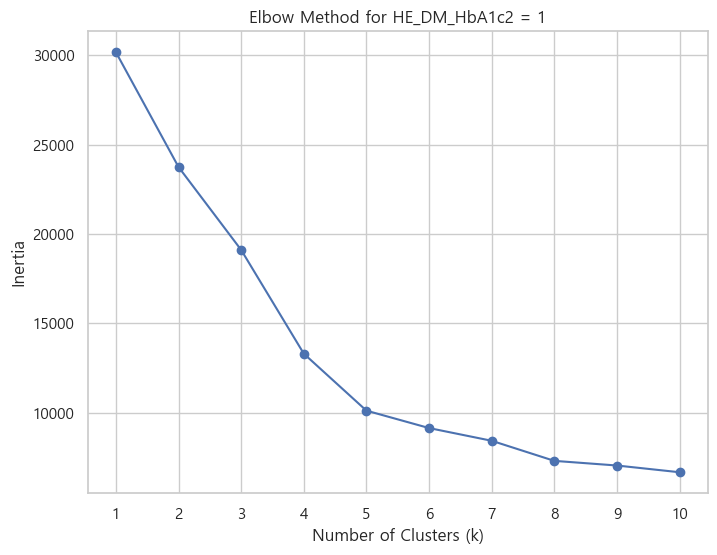

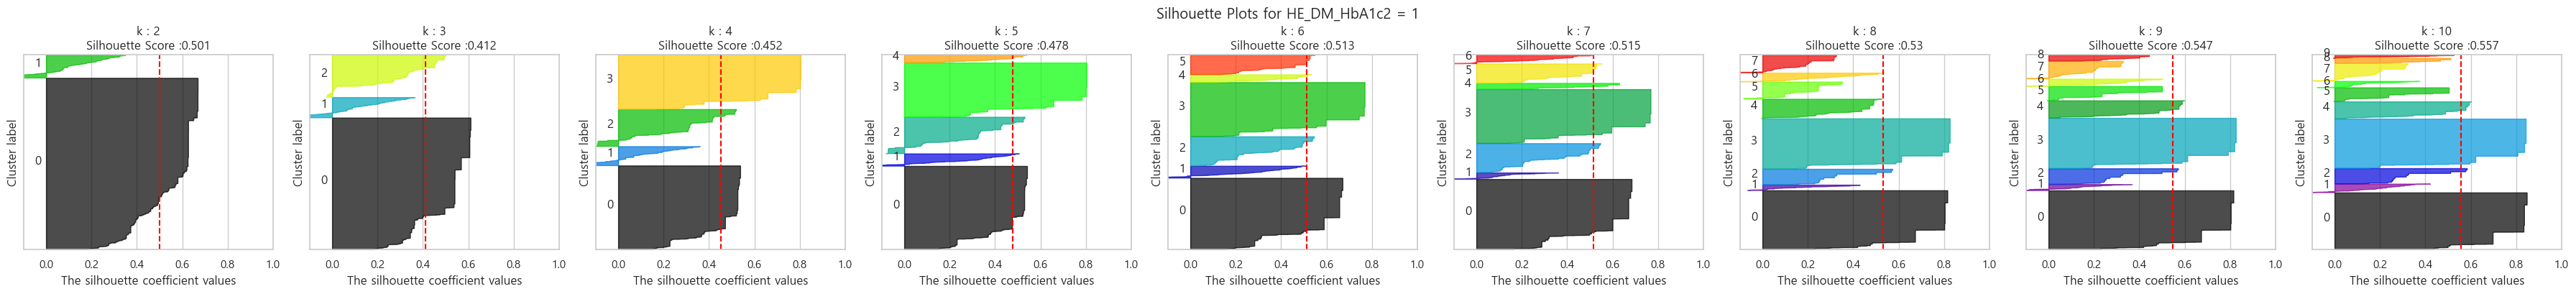


--- Processing HE_DM_HbA1c2 = 2 ---


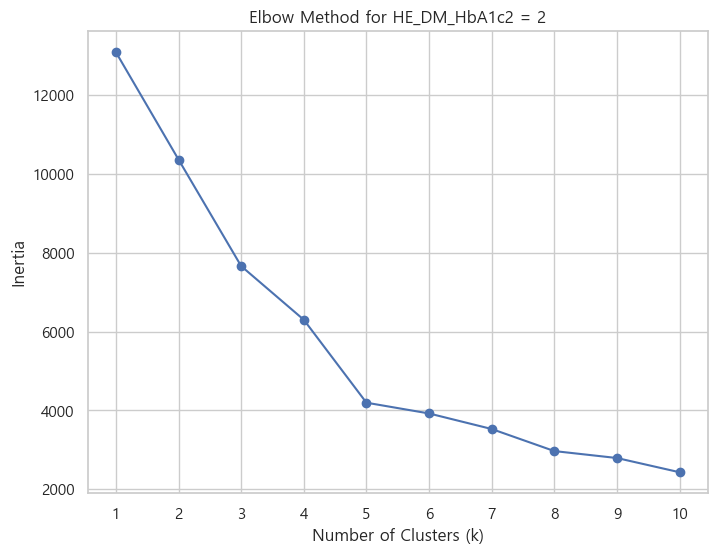

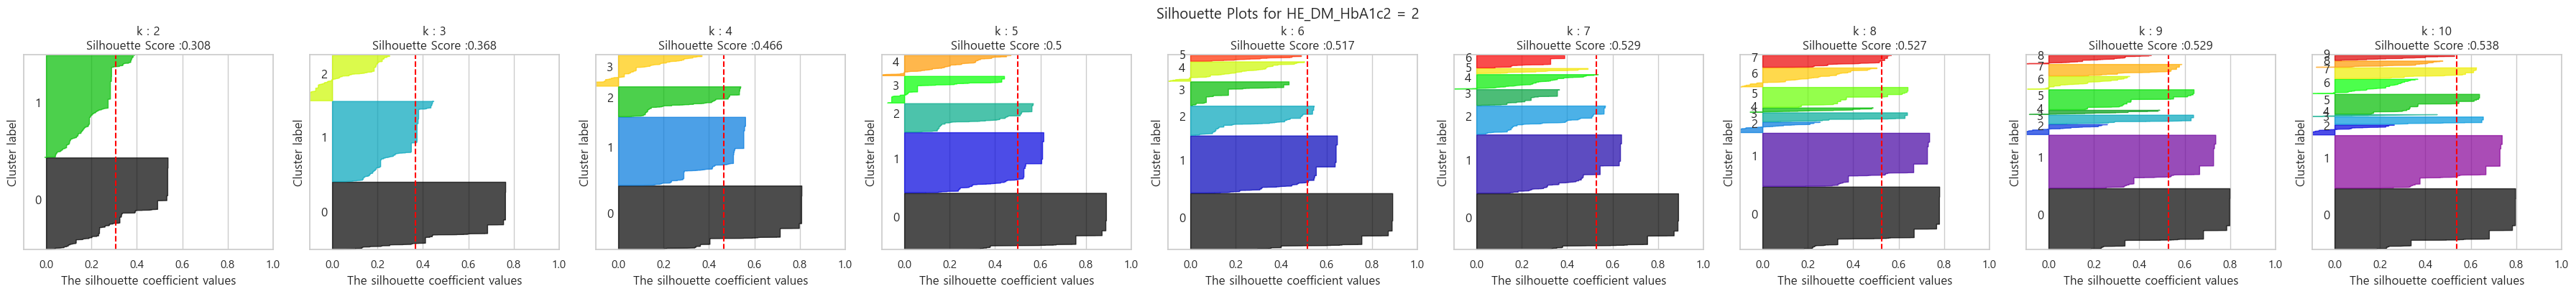


--- Processing HE_DM_HbA1c2 = 3 ---


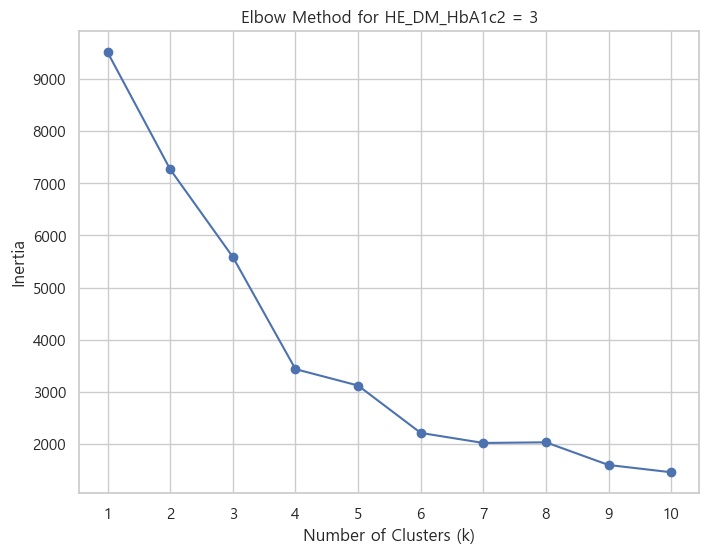

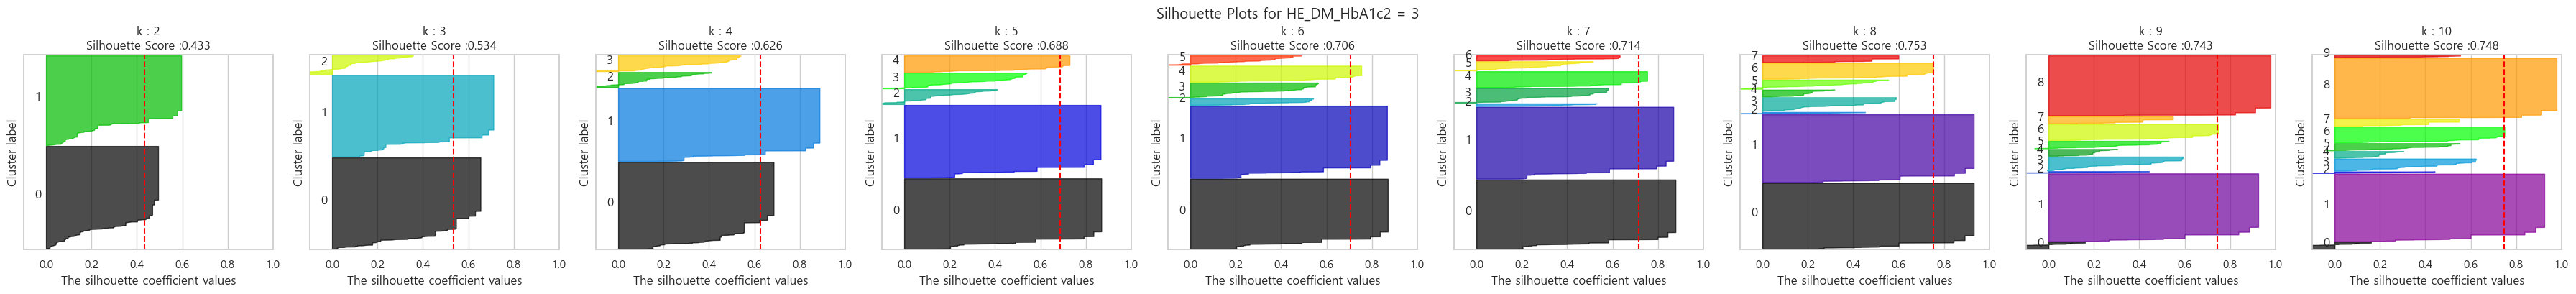


--- Processing HE_DM_HbA1c2 = 4 ---
No data or insufficient data points (0) for HE_DM_HbA1c2 = 4 to perform clustering.

--- Processing complete ---


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans # KMeans 필요
from sklearn.preprocessing import StandardScaler # StandardScaler 필요
from sklearn.metrics import silhouette_samples, silhouette_score # silhouette_samples, silhouette_score 임포트 추가

# Assume df_clustering and knn_columns are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# knn_columns = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI'] # 실제 knn_columns 목록


# 피처 표준화
scaler = StandardScaler()

# 클러스터 수 범위 설정 (엘보우 및 실루엣 시각화에 사용할 최대 k)
k_range_max = 10 # 최대 10개 클러스터까지 탐색

# 결과를 저장할 데이터프레임 준비
# 'Cluster' 칼럼이 이미 있다면 이 줄은 필요 없을 수 있습니다.
# df_clustering['Cluster'] = np.nan

# 군집 분석에 사용할 피처 목록 정의
# 사용자 제공 selected_cols 사용
# selected_cols = knn_columns + ["BD1_11","tobacco","BE5_1","LS_VEG1"] # 이전 정의
selected_cols = ["BD1_11","tobacco","BE5_1","LS_VEG1"] # 사용자 제공 정의

# selected_cols에 포함된 모든 칼럼이 df_clustering에 있는지 확인하는 것이 안전합니다.
if not selected_cols:
    print("Error: selected_cols is empty. Cannot proceed with clustering.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()
else:
    missing_selected_cols = [col for col in selected_cols if col not in df_clustering.columns]
    if missing_selected_cols:
        print(f"Warning: Selected columns not found in df_clustering: {missing_selected_cols}")
        # 데이터에 없는 칼럼은 selected_cols에서 제외하고 진행할 수 있습니다.
        selected_cols = [col for col in selected_cols if col in df_clustering.columns]
        print(f"Using selected_cols found in data: {selected_cols}")

# 필터링 후 selected_cols가 비어있으면 분석 진행 불가
if not selected_cols:
    print("Error: selected_cols is empty after filtering. Cannot proceed with clustering.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()


# HE_DM_HbA1c 별로 반복
# df_clustering['HE_DM_HbA1c'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.
# 실제 df_clustering['HE_DM_HbA1c']의 고유값 리스트를 사용하는 것이 더 안전합니다.
if 'HE_DM_HbA1c2' not in df_clustering.columns:
    print("Error: 'HE_DM_HbA1c2' column not found in df_clustering. Cannot perform clustering by HE_DM_HbA1c2.")
    # 스크립트 실행 중단 또는 적절한 오류 처리
    # exit()

# HE_DM_HbA1c의 실제 고유값 가져오기 및 정렬
# 사용자 제공 [1, 2, 3, 4] 리스트 사용
he_dm_hba1c_values_to_process = [1, 2, 3, 4] # 분석할 HE_DM_HbA1c 값 목록

for HE_DM_HbA1c_value in he_dm_hba1c_values_to_process: # 사용자 제공 HE_DM_HbA1c 값 사용
    print(f"\n--- Processing HE_DM_HbA1c2 = {HE_DM_HbA1c_value} ---")

    # HE_DM_HbA1c 값에 해당하는 데이터 추출
    # selected_cols에 해당하는 칼럼만 선택합니다.
    HE_DM_HbA1c_df = df_clustering[df_clustering['HE_DM_HbA1c2'] == HE_DM_HbA1c_value][selected_cols].copy()

    if not HE_DM_HbA1c_df.empty and len(HE_DM_HbA1c_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 데이터 표준화
        # 각 그룹별로 별도의 scaler를 fit/transform 합니다.
        scaled_df = scaler.fit_transform(HE_DM_HbA1c_df)

        # 클러스터 개수가 데이터 포인트 개수보다 많을 수는 없으므로 범위를 조정
        # 또한, 실루엣 계수 등 다른 검증 지표를 사용하려면 k>1 이어야 합니다.
        max_k_current_group = min(len(scaled_df), k_range_max) # 현재 그룹 데이터 개수와 최대 범위 중 작은 값

        if max_k_current_group < 2:
             print(f"  Not enough data points ({len(scaled_df)}) for HE_DM_HbA1c2 = {HE_DM_HbA1c_value} to perform clustering for k > 1.")
             continue # 다음 HE_DM_HbA1c 값으로 넘어감


        # --- 엘보우 방법: 각 k에 대해 관성(Inertia) 계산 ---
        # 관성을 계산할 k 범위 (최소 1부터 시작)
        k_range_inertia = range(1, max_k_current_group + 1)
        inertias = []
        for k in k_range_inertia:
            # n_init='auto' 또는 숫자로 지정 (최신 sklearn 버전 권장)
            # k=1일때는 n_init=1로 설정 가능
            kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
            kmeans.fit(scaled_df)
            inertias.append(kmeans.inertia_)

        # 엘보우 플롯 시각화
        plt.figure(figsize=(8, 6))
        plt.plot(k_range_inertia, inertias, marker='o')
        plt.title(f'Elbow Method for HE_DM_HbA1c2 = {HE_DM_HbA1c_value}')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Inertia')
        plt.xticks(k_range_inertia) # x축 틱을 k 범위로 설정
        plt.grid(True)
        plt.show()

        # --- 실루엣 계수 시각화 ---
        # 실루엣 계수를 계산할 k 범위 (최소 2부터 시작)
        k_range_silhouette = range(2, max_k_current_group + 1)

        if len(k_range_silhouette) > 0: # k_range_silhouette가 비어있지 않을 때만 시각화
            n_cols = len(k_range_silhouette)

            # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성
            # squeeze=False를 사용하여 n_cols=1일 때도 axs가 항상 2D 배열이 되도록 합니다.
            fig, axs = plt.subplots(figsize=(4 * n_cols, 4), nrows=1, ncols=n_cols, squeeze=False)
            axs = axs.reshape(-1) # 1D 배열로 평탄화

            # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
            for ind, n_cluster in enumerate(k_range_silhouette):
                ax = axs[ind] # 각 서브플롯 선택

                try:
                    # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
                    # n_init='auto' 또는 숫자로 지정 필요
                    clusterer = KMeans(n_clusters=n_cluster, max_iter=500, random_state=0, n_init='auto')
                    cluster_labels = clusterer.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # 데이터 포인트가 1개보다 많고 클러스터 개수가 1개보다 많을 때만 계산 가능
                    if len(np.unique(cluster_labels)) > 1 and scaled_df.shape[0] > 1:
                         sil_avg = silhouette_score(scaled_df, cluster_labels)
                         sil_values = silhouette_samples(scaled_df, cluster_labels)
                    else:
                         sil_avg = 0 # 계산 불가 시 0 또는 NaN으로 처리
                         sil_values = np.zeros(scaled_df.shape[0]) # 모든 샘플 점수 0으로 처리
                         print(f"  Silhouette score not computable for k={n_cluster} (less than 2 clusters or data points).")


                    y_lower = 10 # 첫 번째 클러스터 플롯의 시작 위치

                    # 플롯 제목 설정 (k값 및 평균 실루엣 점수 포함)
                    ax.set_title('k : ' + str(n_cluster)+'\n' \
                                 'Silhouette Score :' + str(round(sil_avg,3)) )
                    ax.set_xlabel("The silhouette coefficient values")
                    ax.set_ylabel("Cluster label")
                    ax.set_xlim([-0.1, 1]) # x축 범위 설정
                    # y축 범위 설정: 데이터 포인트 총 수 + (클러스터 개수 + 1) * 클러스터 간 간격
                    ax.set_ylim([0, len(scaled_df) + (n_cluster + 1) * 10])
                    ax.set_yticks([])  # yaxis labels / ticks 제거
                    ax.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1]) # x축 틱 설정

                    # 각 클러스터별 실루엣 플롯 그리기
                    # 클러스터 라벨 순서대로 정렬하여 그립니다.
                    unique_labels = np.unique(cluster_labels)
                    unique_labels.sort() # 라벨을 오름차순으로 정렬하여 일관성 확보

                    for i in unique_labels: # 정렬된 고유 라벨 순회
                        # i번째 클러스터에 해당하는 실루엣 점수 가져오기
                        ith_cluster_sil_values = sil_values[cluster_labels == i]
                        ith_cluster_sil_values.sort() # 점수 정렬

                        size_cluster_i = ith_cluster_sil_values.shape[0] # 클러스터 i의 샘플 수
                        y_upper = y_lower + size_cluster_i # 현재 클러스터 플롯의 끝 위치

                        # 클러스터 색상 설정
                        color = cm.nipy_spectral(float(i) / len(unique_labels)) # 고유 라벨 개수로 색상 스케일링
                        # fill_betweenx를 사용하여 실루엣 점수 영역 채우기
                        ax.fill_betweenx(np.arange(y_lower, y_upper),
                                         0, ith_cluster_sil_values,
                                         facecolor=color, edgecolor=color, alpha=0.7)

                        # 클러스터 번호 텍스트 추가
                        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

                        # 다음 클러스터 플롯을 위한 y_lower 위치 업데이트
                        y_lower = y_upper + 10 # 클러스터 간 간격 추가

                    # 평균 실루엣 점수 라인 추가
                    ax.axvline(x=sil_avg, color="red", linestyle="--")

                except Exception as e:
                    print(f"  Error visualizing silhouette for k={n_cluster}: {e}")
                    ax.set_title(f'k={n_cluster} (Error)')
                    ax.text(0.5, 0.5, 'Error', horizontalalignment='center', verticalalignment='center')
                    ax.set_xticks([])
                    ax.set_yticks([])

            # 전체 플롯 레이아웃 조정 및 제목 추가
            plt.tight_layout()
            plt.suptitle(f'Silhouette Plots for HE_DM_HbA1c2 = {HE_DM_HbA1c_value}', y=1.02) # 전체 제목에 HE_DM_HbA1c 값 포함
            plt.show()

        else:
            print(f"  Not enough data points ({len(scaled_df)}) for HE_DM_HbA1c2 = {HE_DM_HbA1c_value} to perform clustering for k > 1 for silhouette visualization.")



    else:
        print(f"No data or insufficient data points ({len(HE_DM_HbA1c_df)}) for HE_DM_HbA1c2 = {HE_DM_HbA1c_value} to perform clustering.")
        # 데이터가 없거나 부족하면 해당 HE_DM_HbA1c 값에 대한 클러스터 라벨을 NaN으로 유지
        # df_clustering.loc[HE_DM_HbA1c_df.index, 'Cluster'] = np.nan # 이미 초기화 시 np.nan 이므로 필요 없을 수 있습니다.


print("\n--- Processing complete ---")

# 루프가 완료된 후, df_clustering 데이터프레임에는 각 HE_DM_HbA1c 그룹에 대해
# 결정된 optimal_k로 군집화된 'Cluster' 라벨이 추가되어 있습니다.
# 이제 이 df_clustering를 사용하여 군집별 특징 분석, 시각화 등을 수행할 수 있습니다.


3개 방법 비교 


--- Processing HE_DM_HbA1c = 1 with k = 6 ---
Comparing algorithms for k = 6:
  - KMeans: Silhouette Score = 0.4888
  - Agglomerative: Silhouette Score = 0.4361
  - MiniBatchKMeans: Silhouette Score = 0.4433

Best algorithm for HE_DM_HbA1c = 1 (k=6): KMeans (Silhouette Score: 0.4888)
Cluster Characteristics (Mean values for HE_DM_HbA1c = 1, k=6):
             1년 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  1년 동안 평균 채소류 섭취 빈도
New_Cluster                                                        
0             32.209302   0.988372     0.401993          340.083056
1             31.196911   0.289575     0.239382          730.000000
2             64.762148  17.826087     0.562660          765.332481
3             21.548673   0.330383     0.175516         1095.000000
4             33.651877   0.803185     4.158134          848.427759
5            286.000000   5.569038     0.853556          796.422594
------------------------------------------------------------


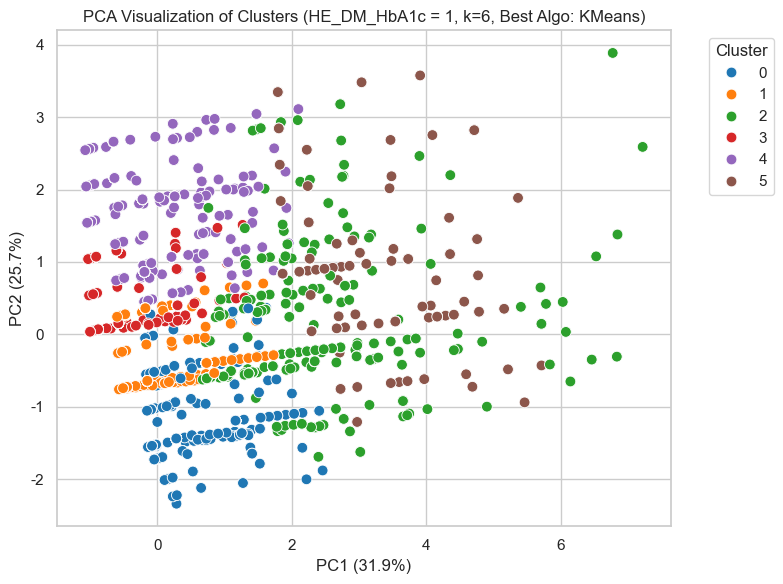


--- Processing HE_DM_HbA1c = 2 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.5040
  - Agglomerative: Silhouette Score = 0.4362
  - MiniBatchKMeans: Silhouette Score = 0.5040

Best algorithm for HE_DM_HbA1c = 2 (k=5): KMeans (Silhouette Score: 0.5040)
Cluster Characteristics (Mean values for HE_DM_HbA1c = 2, k=5):
             1년 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  1년 동안 평균 채소류 섭취 빈도
New_Cluster                                                        
0             74.756014  19.463918     0.439863          793.367698
1             30.330852   0.732837     0.188586          662.603805
2             32.254545   0.842424     4.301010          911.442424
3             23.968750   0.373264     0.126736         1095.000000
4            286.000000   6.004405     0.762115          843.242291
------------------------------------------------------------


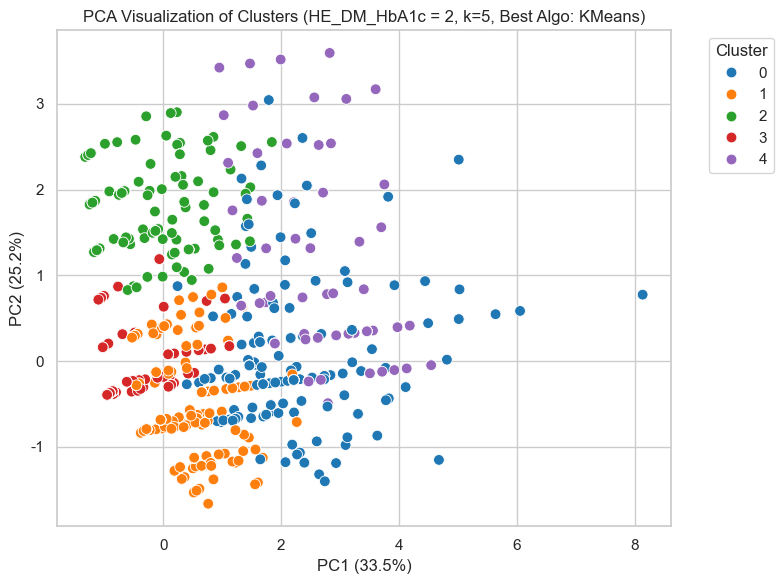


--- Processing HE_DM_HbA1c = 3 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.5656
  - Agglomerative: Silhouette Score = 0.5289
  - MiniBatchKMeans: Silhouette Score = 0.5636

Best algorithm for HE_DM_HbA1c = 3 (k=5): KMeans (Silhouette Score: 0.5656)
Cluster Characteristics (Mean values for HE_DM_HbA1c = 3, k=5):
             1년 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  1년 동안 평균 채소류 섭취 빈도
New_Cluster                                                        
0             18.438519   0.410370     0.105185         1095.000000
1             20.296460   0.738938     0.154867          675.630531
2             34.205357   2.084821     4.321429          966.272321
3            286.000000   5.470588     0.784314          901.764706
4             77.365517  20.779310     0.220690          804.434483
------------------------------------------------------------


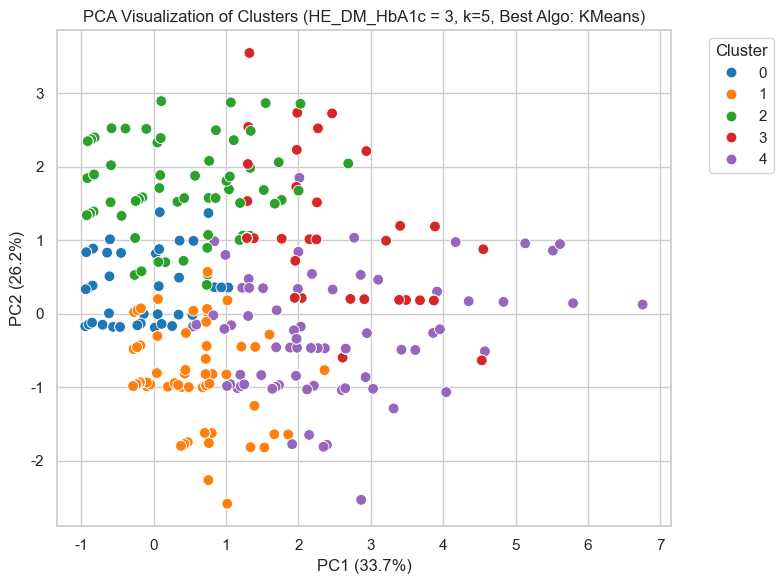


--- Processing complete ---


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans # AgglomerativeClustering, DBSCAN, MiniBatchKMeans 임포트 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# RandomForestClassifier는 이 특정 스니펫에서 직접 사용되지 않으므로 주석 처리하거나 필요에 따라 유지
# from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트 (이 스니펫에서 직접 사용되지는 않음)
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.stats.contingency_tables import Table

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def preprocess_data(df, original_numeric_cols, original_categorical_cols): ...

# select_features 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def select_features(df, columns, corr_threshold=0.8): ...

# compute_feature_importance 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def compute_feature_importance(df_processed, selected_cols, cluster_labels): ...

# visualize_silhouette 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def visualize_silhouette(cluster_lists, X_features): ...

# run_clustering_iteration 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm): ...


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
# 이 딕셔너리는 selected_cols에 있는 피처 이름에 대한 설명을 포함해야 합니다.
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1년 간 음주 빈도',
    'tobacco': '하루평균 흡연량', # 이 피처가 selected_cols에 있는지 확인 필요
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '1년 동안 평균 채소류 섭취 빈도',
    # selected_cols에 포함된 다른 피처들도 여기에 추가해야 합니다.
    'age': '나이', 'sex': '성별', 'HE_HbA1c': '당화혈색소', # 예시 추가
    # ... selected_cols에 있는 모든 피처에 대한 매핑 추가 ...
}

# 시각화 설정
sns.set(style="whitegrid")

# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# selected_cols = ['HE_sbp1', 'HE_dbp1', 'HE_wc', 'HE_glu', 'HE_chol', 'HE_HDL_st2', 'HE_LDL_drct', 'HE_crea', 'HE_ast', 'HE_alt', 'HE_wt', 'HE_ht', 'HE_BMI', 'BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1', 'age', 'sex', 'HE_HbA1c'] # 실제 selected_cols 목록
# scaler = StandardScaler() # 스케일러 객체 (fit 되어 있어야 함)
# df_clustering['HE_DM_HbA1c'] 칼럼이 존재하고, 그 값이 [1, 2, 3] 중에 있다고 가정합니다.


# 비교할 군집화 알고리즘 정의 (n_clusters를 사용하는 알고리즘)
# K-Means, Agglomerative, MiniBatchKMeans 포함
algorithms_to_compare = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'MiniBatchKMeans': MiniBatchKMeans,
    # DBSCAN은 n_clusters 기반 비교가 적합하지 않아 이 비교 루프에서는 제외합니다.
}


# HE_DM_HbA1c 별로 반복
# optimal_k 리스트는 각 HE_DM_HbA1c 값에 대해 미리 결정되어 있어야 합니다.
# 예: optimal_k_list = [3, 5, 5]
# HE_DM_HbA1c_values = [1, 2, 3] # 실제 HE_DM_HbA1c 고유값
# for HE_DM_HbA1c_value, optimal_k in zip(HE_DM_HbA1c_values, optimal_k_list):

for HE_DM_HbA1c_value, optimal_k in zip([1, 2, 3], [6, 5, 6]): # 제공해주신 예시 값 사용
    print(f"\n--- Processing HE_DM_HbA1c = {HE_DM_HbA1c_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함
    # df_clustering는 이전에 로드/처리되어 있어야 함
    HE_DM_HbA1c_df = df_clustering[df_clustering['HE_DM_HbA1c'] == HE_DM_HbA1c_value][selected_cols].copy()

    if not HE_DM_HbA1c_df.empty:
        # 표준화 (각 그룹별로 스케일링)
        # scaler는 이전에 fit 되어 있어야 하지만, 여기서는 각 그룹별로 fit_transform을 다시 수행합니다.
        # 만약 전체 데이터로 fit 했다면 여기서 transform만 사용해야 합니다.
        # 제공해주신 코드 형태대로 매 그룹별로 fit_transform 하는 경우를 따릅니다.
        scaled_df = scaler.fit_transform(HE_DM_HbA1c_df)

        # --- 다양한 군집화 알고리즘 비교 ---
        best_score = -1 # 가장 높은 실루엣 점수 추적
        best_labels = None # 가장 좋은 알고리즘의 클러스터 라벨 추적
        best_algo_name = None # 가장 좋은 알고리즘 이름 추적

        print(f"Comparing algorithms for k = {optimal_k}:")

        for algo_name, algo_class in algorithms_to_compare.items():
            try:
                # 클러스터 개수가 1개보다 많고, 데이터 포인트가 1개보다 많을 때만 유효한 비교
                if optimal_k > 1 and scaled_df.shape[0] > 1:
                    # 알고리즘 인스턴스 생성
                    if algo_name in ['KMeans', 'MiniBatchKMeans']: # KMeans 또는 MiniBatchKMeans
                        # n_init='auto' 또는 숫자로 지정 필요
                        model = algo_class(n_clusters=optimal_k, random_state=42, n_init='auto')
                    else: # Agglomerative Clustering
                        # Agglomerative Clustering은 n_init 매개변수 없음
                        model = algo_class(n_clusters=optimal_k)

                    # 클러스터링 수행
                    current_labels = model.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # DBSCAN과 달리 이 알고리즘들은 모든 데이터에 라벨을 할당하므로 노이즈 제외 로직은 필요 없습니다.
                    current_score = silhouette_score(scaled_df, current_labels)
                    print(f"  - {algo_name}: Silhouette Score = {current_score:.4f}")

                    # 가장 높은 점수 업데이트
                    if current_score > best_score:
                        best_score = current_score
                        best_labels = current_labels # 현재 알고리즘의 라벨 저장
                        best_algo_name = algo_name # 현재 알고리즘 이름 저장

                else:
                    # 클러스터 개수가 1개 이하이거나 데이터 포인트가 부족하면 실루엣 점수 계산 불가
                    print(f"  - {algo_name}: Silhouette Score not computable (k<2 or insufficient data).")
                    # best_score는 여전히 -1 (초기값) 유지

            except Exception as e:
                print(f"  - {algo_name} failed: {e}")
                # 오류 발생 시 해당 알고리즘은 무시하고 계속 진행

        # --- 가장 높은 실루엣 점수를 가진 알고리즘의 결과 사용 ---
        if best_labels is not None:
            print(f"\nBest algorithm for HE_DM_HbA1c = {HE_DM_HbA1c_value} (k={optimal_k}): {best_algo_name} (Silhouette Score: {best_score:.4f})")
            final_cluster_labels = best_labels # 가장 좋은 라벨 사용
        else:
            print(f"\nCould not find a suitable clustering result for HE_DM_HbA1c = {HE_DM_HbA1c_value} (k={optimal_k}). Skipping analysis for this group.")
            continue # 이 그룹에 대한 분석 건너뛰기

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 최종 클러스터 라벨 추가
        # 인덱스가 맞아야 함
        HE_DM_HbA1c_df_with_labels = HE_DM_HbA1c_df.copy() # 원본 df 변경 방지를 위해 복사
        HE_DM_HbA1c_df_with_labels['New_Cluster'] = final_cluster_labels # 가장 좋은 라벨 사용

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산
        cluster_characteristics = HE_DM_HbA1c_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # 3. 결과 출력을 위해 컬럼 이름을 한글로 변경
        # selected_cols에 포함된 피처 이름만 매핑 (딕셔너리에 없는 컬럼은 원래 이름 유지)
        cols_to_rename = {col: feature_korean_names.get(col, col) for col in cluster_characteristics.columns}
        cluster_characteristics = cluster_characteristics.rename(columns=cols_to_rename)

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_DM_HbA1c = {HE_DM_HbA1c_value}, k={optimal_k}):")
        print(cluster_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 final_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = final_cluster_labels

        # PCA 2차원 축소
        # 스케일링된 데이터를 PCA에 사용
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df) # 스케일링된 데이터를 PCA에 사용

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 최종 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        # 제목에 HE_DM_HbA1c 값, k값, 사용된 알고리즘 이름 추가
        plt.title(f'PCA Visualization of Clusters (HE_DM_HbA1c = {HE_DM_HbA1c_value}, k={optimal_k}, Best Algo: {best_algo_name})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data for HE_DM_HbA1c = {HE_DM_HbA1c_value}")
        print("-" * 60) # 구분선

print("\n--- Processing complete ---")



--- Processing HE_DM_HbA1c2 = 1 with k = 6 ---
Comparing algorithms for k = 6:
  - KMeans: Silhouette Score = 0.4824
  - Agglomerative: Silhouette Score = 0.5028
  - MiniBatchKMeans: Silhouette Score = 0.4832

Best algorithm for HE_DM_HbA1c2 = 1 (k=6): Agglomerative (Silhouette Score: 0.5028)
Cluster Characteristics (Mean values for HE_DM_HbA1c2 = 1, k=6) - Modified:
             1주일 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  하루 평균 채소 섭취 빈도
New_Cluster                                                     
0               0.254062   0.122122     0.229229        1.798903
1               1.059499  15.119697     0.901515        2.022204
2               0.530163   0.119069     4.122650        2.284348
3               0.174336   0.318113     0.159310        3.000000
4               5.490291   6.954693     0.915858        2.204087
5               2.500000   0.362705     0.262295        2.073479
------------------------------------------------------------


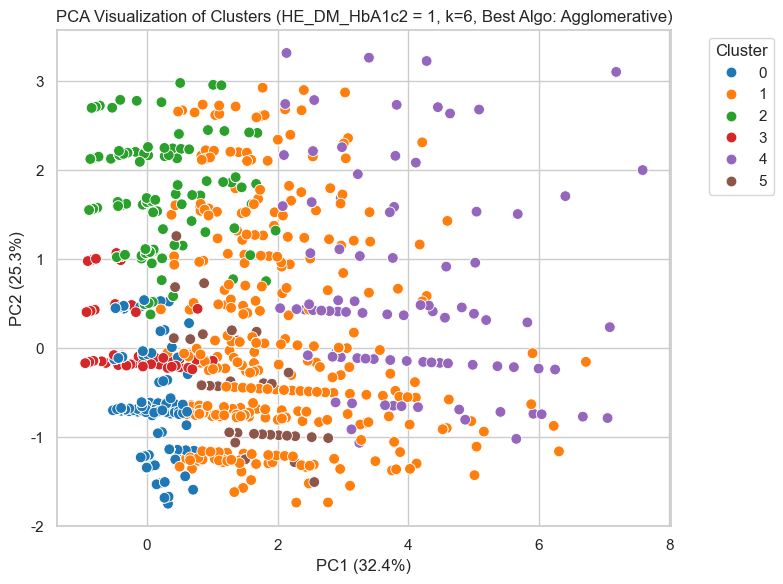


--- Processing HE_DM_HbA1c2 = 2 with k = 5 ---
Comparing algorithms for k = 5:
  - KMeans: Silhouette Score = 0.4991
  - Agglomerative: Silhouette Score = 0.4614
  - MiniBatchKMeans: Silhouette Score = 0.4992

Best algorithm for HE_DM_HbA1c2 = 2 (k=5): MiniBatchKMeans (Silhouette Score: 0.4992)
Cluster Characteristics (Mean values for HE_DM_HbA1c2 = 2, k=5) - Modified:
             1주일 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  하루 평균 채소 섭취 빈도
New_Cluster                                                     
0               0.566911   0.702749     0.197595        1.824961
1               1.802284  18.803125     0.415625        2.089024
2               0.630738   0.783951     4.275720        2.521890
3               0.475355   0.439671     0.115174        3.000000
4               5.500000   4.552885     0.836538        2.418269
------------------------------------------------------------


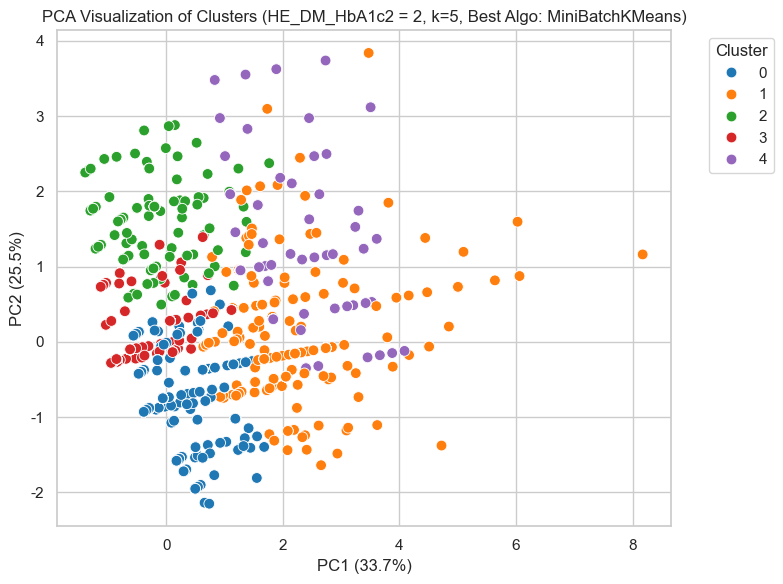


--- Processing HE_DM_HbA1c2 = 3 with k = 6 ---
Comparing algorithms for k = 6:
  - KMeans: Silhouette Score = 0.7047
  - Agglomerative: Silhouette Score = 0.7345
  - MiniBatchKMeans: Silhouette Score = 0.6719

Best algorithm for HE_DM_HbA1c2 = 3 (k=6): Agglomerative (Silhouette Score: 0.7345)
Cluster Characteristics (Mean values for HE_DM_HbA1c2 = 3, k=6) - Modified:
             1주일 간 음주 빈도   하루평균 흡연량  1주일 간 운동 횟수  하루 평균 채소 섭취 빈도
New_Cluster                                                     
0               1.784658  17.703297     0.192308        2.244889
1               3.792308   1.007692     0.115385        2.500000
2               0.928846   1.895833     3.808333        2.562820
3               0.066074   0.001211     0.000000        3.000000
4               0.058598   0.089005     0.057592        0.885763
5               0.061463   0.013564     0.018496        2.000000
------------------------------------------------------------


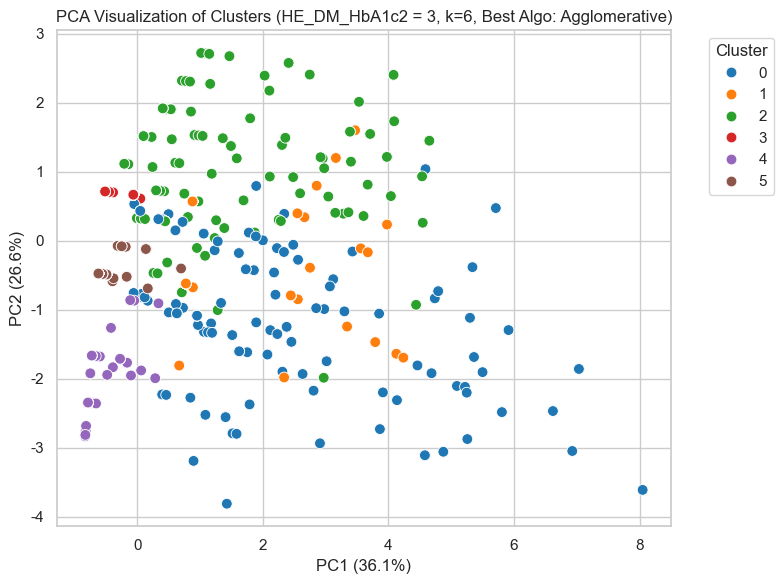


--- Processing complete ---


In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm # For silhouette plot colors
import seaborn as sns

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans # AgglomerativeClustering, DBSCAN, MiniBatchKMeans 임포트 추가
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

# RandomForestClassifier는 이 특정 스니펫에서 직접 사용되지 않으므로 주석 처리하거나 필요에 따라 유지
# from sklearn.ensemble import RandomForestClassifier

# 통계 분석을 위한 라이브러리 임포트 (이 스니펫에서 직접 사용되지는 않음)
# from scipy import stats
# import statsmodels.api as sm
# from statsmodels.stats.contingency_tables import Table

# 시각화 설정
sns.set(style="whitegrid")

# 전처리 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def preprocess_data(df, original_numeric_cols, original_categorical_cols): ...

# select_features 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def select_features(df, columns, corr_threshold=0.8): ...

# compute_feature_importance 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def compute_feature_importance(df_processed, selected_cols, cluster_labels): ...

# visualize_silhouette 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def visualize_silhouette(cluster_lists, X_features): ...

# run_clustering_iteration 함수 (이 스니펫에서 정의되지 않았지만, 외부에서 정의되어 사용된다고 가정)
# def run_clustering_iteration(df_original, features_to_use, original_numeric_cols, original_categorical_cols, n_clusters, algorithm): ...


# 매핑 딕셔너리 정의 (피처 이름 -> 한글 설명)
# 이 딕셔너리는 selected_cols에 있는 피처 이름에 대한 설명을 포함해야 합니다.
# 이 딕셔너리는 PCA 플롯 등의 원래 피처 라벨링에 사용됩니다.
feature_korean_names = {
    'HE_sbp1': '수축기 혈압 (최고 혈압)',
    'HE_dbp1': '이완기 혈압 (최저 혈압)',
    'HE_wc': '허리둘레',
    'HE_glu': '혈당',
    'HE_chol': '총 콜레스테롤',
    'HE_HDL_st2': 'HDL 콜레스테롤 (좋은 콜레스테롤)',
    'HE_LDL_drct': 'LDL 콜레스테롤 (나쁜 콜레스테롤)',
    'HE_crea': '크레아티닌 (신장 기능 지표)',
    'HE_ast': 'AST (간 기능 검사, GOT)',
    'HE_alt': 'ALT (간 기능 검사, GPT)',
    'HE_wt': '체중',
    'HE_ht': '키',
    'HE_BMI': '체질량 지수 (BMI)',
    'BD1_11': '1주일 간 음주 빈도', # 원본 피처 이름 유지
    'tobacco': '하루 평균 흡연량',
    'BE5_1' : '1주일 간 운동 횟수',
    'LS_VEG1': '하루 평균 채소류 섭취 빈도', # 원본 피처 이름 유지
    # selected_cols에 포함된 다른 피처들도 여기에 추가해야 합니다.
    'age': '나이', 'sex': '성별', 'HE_HbA1c': '당화혈색소', # 예시 추가
    # ... selected_cols에 있는 모든 피처에 대한 매핑 추가 ...
}

# 시각화 설정
sns.set(style="whitegrid")

# Assume df_clustering, selected_cols, scaler are defined and initialized before this snippet
# 예시 정의 (실제 코드에서는 이전에 정의된 변수를 사용해야 합니다)
# df_clustering = pd.read_csv("your_clustering_data.csv") # 실제 파일 경로
# selected_cols는 이전에 정의되어 있어야 함 (예: ['BD1_11', 'tobacco', 'BE5_1', 'LS_VEG1'])
# scaler = StandardScaler() # 스케일러 객체 (fit 되어 있어야 함)
# df_clustering['HE_HP'] 칼럼이 존재하고, 그 값이 [1, 2, 3, 4] 중에 있다고 가정합니다.


# 비교할 군집화 알고리즘 정의 (n_clusters를 사용하는 알고리즘)
# MiniBatchKMeans 추가
algorithms_to_compare = {
    'KMeans': KMeans,
    'Agglomerative': AgglomerativeClustering,
    'MiniBatchKMeans': MiniBatchKMeans, # MiniBatchKMeans 추가
    # DBSCAN은 n_clusters 대신 다른 매개변수를 사용하므로 이 비교 루프에서는 제외합니다.
}

# 군집 분석에 사용할 피처 목록 정의 (원본 데이터 기준)
selected_cols = ["BD1_11","tobacco","BE5_1","LS_VEG1"]

# 피처 표준화 (전체 데이터에 대해 한 번 fit 할 수도 있고, 각 그룹별로 fit 할 수도 있습니다.
# 제공해주신 코드 형태대로 각 그룹별로 fit_transform 하는 경우를 따릅니다.)
scaler = StandardScaler()


# HE_HP 별로 반복
# optimal_k 리스트는 각 HE_HP 값에 대해 미리 결정되어 있어야 합니다.
# 예: optimal_k_list = [5, 5, 5, 5]
# HE_HP_values = [1, 2, 3, 4] # 실제 HE_HP 고유값
# for hp_value, optimal_k in zip(HE_HP_values, optimal_k_list):

for HE_DM_HbA1c_value, optimal_k in zip([1, 2, 3], [6, 5, 6]): # 제공해주신 예시 값 사용
    print(f"\n--- Processing HE_DM_HbA1c2 = {HE_DM_HbA1c_value} with k = {optimal_k} ---")

    # 해당 그룹 데이터 추출
    # selected_cols는 이전에 정의되어 있어야 함
    # df_clustering는 이전에 로드/처리되어 있어야 함
    HE_DM_HbA1c_df = df_clustering[df_clustering['HE_DM_HbA1c2'] == HE_DM_HbA1c_value][selected_cols].copy()

    if not HE_DM_HbA1c_df.empty and len(HE_DM_HbA1c_df) > 1: # 데이터 포인트가 1개보다 많아야 클러스터링 의미 있음
        # 표준화 (각 그룹별로 스케일링)
        # scaler는 이전에 fit 되어 있어야 하지만, 여기서는 각 그룹별로 fit_transform을 다시 수행합니다.
        # 만약 전체 데이터로 fit 했다면 여기서 transform만 사용해야 합니다.
        # 제공해주신 코드 형태대로 매 그룹별로 fit_transform 하는 경우를 따릅니다.
        scaled_df = scaler.fit_transform(HE_DM_HbA1c_df)

        # --- 다양한 군집화 알고리즘 비교 ---
        best_score = -1 # 가장 높은 실루엣 점수 추적
        best_labels = None # 가장 좋은 알고리즘의 클러스터 라벨 추적
        best_algo_name = None # 가장 좋은 알고리즘 이름 추적

        print(f"Comparing algorithms for k = {optimal_k}:")

        for algo_name, algo_class in algorithms_to_compare.items():
            try:
                # 클러스터 개수가 1개보다 많고, 데이터 포인트가 1개보다 많을 때만 유효한 비교
                if optimal_k > 1 and scaled_df.shape[0] > 1:
                    # 알고리즘 인스턴스 생성
                    if algo_name in ['KMeans', 'MiniBatchKMeans']: # KMeans 또는 MiniBatchKMeans
                        # n_init='auto' 또는 숫자로 지정 필요
                        model = algo_class(n_clusters=optimal_k, random_state=42, n_init='auto')
                    else: # Agglomerative Clustering
                        # Agglomerative Clustering은 n_init 매개변수 없음
                        model = algo_class(n_clusters=optimal_k)

                    # 클러스터링 수행
                    current_labels = model.fit_predict(scaled_df)

                    # 실루엣 점수 계산
                    # DBSCAN과 달리 이 알고리즘들은 모든 데이터에 라벨을 할당하므로 노이즈 제외 로직은 필요 없습니다.
                    current_score = silhouette_score(scaled_df, current_labels)
                    print(f"  - {algo_name}: Silhouette Score = {current_score:.4f}")

                    # 가장 높은 점수 업데이트
                    if current_score > best_score:
                        best_score = current_score
                        best_labels = current_labels # 현재 알고리즘의 라벨 저장
                        best_algo_name = algo_name # 현재 알고리즘 이름 저장

                else:
                    # 클러스터 개수가 1개 이하이거나 데이터 포인트가 부족하면 실루엣 점수 계산 불가
                    print(f"  - {algo_name}: Silhouette Score not computable (k<2 or insufficient data).")
                    # best_score는 여전히 -1 (초기값) 유지

            except Exception as e:
                print(f"  - {algo_name} failed: {e}")
                # 오류 발생 시 해당 알고리즘은 무시하고 계속 진행

        # --- 가장 높은 실루엣 점수를 가진 알고리즘의 결과 사용 ---
        if best_labels is not None:
            print(f"\nBest algorithm for HE_DM_HbA1c2 = {HE_DM_HbA1c_value} (k={optimal_k}): {best_algo_name} (Silhouette Score: {best_score:.4f})")
            final_cluster_labels = best_labels # 가장 좋은 라벨 사용
        else:
            print(f"\nCould not find a suitable clustering result for HE_DM_HbA1c2 = {HE_DM_HbA1c_value} (k={optimal_k}). Skipping analysis for this group.")
            continue # 이 그룹에 대한 분석 건너뛰기

        # 군집별 특징 계산 및 출력
        # 1. 원본 데이터프레임에 최종 클러스터 라벨 추가
        # 인덱스가 맞아야 함
        HE_DM_HbA1c_df_with_labels = HE_DM_HbA1c_df.copy() # 원본 hp_df 변경 방지를 위해 복사
        HE_DM_HbA1c_df_with_labels['New_Cluster'] = final_cluster_labels # 가장 좋은 라벨 사용

        # 2. 'New_Cluster' 기준으로 그룹화하고 각 피처의 평균 계산 (원본 스케일)
        cluster_characteristics_original = HE_DM_HbA1c_df_with_labels.groupby('New_Cluster')[selected_cols].mean()

        # --- 출력 테이블을 위한 데이터 변환 및 컬럼 이름 변경 ---
        # '1년 간 음주 빈도'를 '1주일 간 음주 빈도'로 (평균 / 52)
        weekly_alcohol = cluster_characteristics_original['BD1_11'] / 52

        # '1년 동안 평균 채소류 섭취 빈도'를 '하루 평균 채소 섭취 빈도'로 (평균 / 365)
        daily_veg = cluster_characteristics_original['LS_VEG1'] / 365

        # 나머지 피처는 그대로 사용
        daily_smoking = cluster_characteristics_original['tobacco']
        weekly_exercise = cluster_characteristics_original['BE5_1']

        # 새로운 컬럼 이름으로 결과 데이터프레임 생성
        output_characteristics = pd.DataFrame({
            '1주일 간 음주 빈도': weekly_alcohol,
            '하루평균 흡연량': daily_smoking,
            '1주일 간 운동 횟수': weekly_exercise,
            '하루 평균 채소 섭취 빈도': daily_veg
        })

        # 4. 결과 출력
        print(f"Cluster Characteristics (Mean values for HE_DM_HbA1c2 = {HE_DM_HbA1c_value}, k={optimal_k}) - Modified:")
        print(output_characteristics)
        print("-" * 60) # 구분선

        # 클러스터 라벨 변수 이름을 final_cluster_labels로 변경 (혼동 방지)
        cluster_labels_for_pca = final_cluster_labels

        # PCA 2차원 축소
        # 스케일링된 데이터를 PCA에 사용 (원본 selected_cols 기준)
        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(scaled_df) # 스케일링된 데이터를 PCA에 사용

        # 결과를 데이터프레임으로 변환
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])
        # 최종 클러스터 라벨 사용
        pca_df['Cluster'] = cluster_labels_for_pca.astype(int)

        # 시각화 (나머지 코드 동일) - PCA 플롯의 축 이름은 PC1, PC2로 유지
        plt.figure(figsize=(8, 6))
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Cluster', palette='tab10', s=60)
        # 제목에 HE_HP 값, k값, 사용된 알고리즘 이름 추가
        plt.title(f'PCA Visualization of Clusters (HE_DM_HbA1c2 = {HE_DM_HbA1c_value}, k={optimal_k}, Best Algo: {best_algo_name})')
        plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)')
        plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)')
        plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    else:
        print(f"No data or insufficient data points ({len(HE_DM_HbA1c_df)}) for HE_DM_HbA1c2 = {HE_DM_HbA1c_value} to perform clustering.")
        print("-" * 60) # 구분선

print("\n--- Processing complete ---")
